## Setup Environment

In [1]:
%reload_ext autoreload
%autoreload 2/
%matplotlib inline

In [2]:
import pathlib
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import optim

from sklearn.model_selection import train_test_split
from time import time
from tqdm import tqdm

In [3]:
# For training on Colab
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab_Notebooks/융캡')

Mounted at /content/drive


## Declare Constants

In [4]:
MAX_LEN = 120
NLATENT = 196
DECODER_HIDDEN_SIZE = 488
DECODER_NUM_LAYERS = 3

DATA_DIR = './chemical_vae_pytorch/data'
DATA_FILE_NAME = '250k_rndm_zinc_drugs_clean_3.csv'
CHAR_FILE_NAME = 'zinc.json'
TEST_IDX_FILE_NAME = 'test_idx.npy'

ALL_LETTERS = yaml.safe_load(open(pathlib.Path(DATA_DIR, CHAR_FILE_NAME))) + ['SOS']
N_LETTERS = len(ALL_LETTERS)

MODELS_DIR = './chemical_vae_pytorch/models'

## Create a Utility Class

In [5]:
class VAEUtils:
    '''
    This purpose of this class is to help with various aspects
    of data processing
    '''

    def __init__(self, data_dir=DATA_DIR,
                 data_file_name=DATA_FILE_NAME,
                 test_idx_file_name=TEST_IDX_FILE_NAME,
                 max_len=MAX_LEN,
                 all_letters=ALL_LETTERS):

        self.data_dir = pathlib.Path(data_dir)
        self.data_file = self.data_dir / pathlib.Path(data_file_name)
        self.test_file = self.data_dir / pathlib.Path(test_idx_file_name)

        self.max_len = max_len

        self.all_letters = all_letters
        self.n_letters = len(all_letters)
        self.letters_to_indices_dict = dict((l, i) for i, l in enumerate(all_letters))
        self.indices_to_letters_dict = dict((i, l) for i, l in enumerate(all_letters))

    def get_data_df(self):
        df = pd.read_csv(self.data_file)
        df = df[df.smiles.str.len() <= self.max_len].reset_index(drop=True)

        # SMILES 문자열의 길이가 max_len보다 작거나 같은 행들로 제한하고, 불필요한 공백을 제거하고 오른쪽으로 패딩
        df.loc[:, 'smiles'] = df.loc[:, 'smiles'].str.strip()\
                    .str.pad(width=self.max_len, side='right', fillchar=" ")

        return df

    # One-hot matrix of first to last letters (not including EOS) for input
    def get_input_tensor(self, smile): # 사전 정의된 문자 세트를 사용하여 SMILES 문자열을 원-핫 인코딩된 텐서로 변환
        tensor = torch.zeros(1, len(smile), self.n_letters) # batch_size * seq_length * num_features
        for i, letter in enumerate(smile):
            tensor[0][i][self.letters_to_indices_dict[letter]] = 1
        return tensor

    # LongTensor of first letter to end (EOS) for target
    def get_target_tensor(self, smile): # SMILES 문자열을 인덱스 텐서로 변환
        letter_indexes = [self.letters_to_indices_dict[l] for l in smile]
        # letter_indexes.append(self.n_letters - 1) # EOS
        return torch.LongTensor(letter_indexes)

    def get_train_valid_test_splits(self, reg_col, valid_pct=.1):
        df = self.get_data_df()[['smiles', reg_col]]
        df = df.rename(columns={reg_col: 'reg_col'})

        test_idx = np.load(self.test_file)
        non_test_idx = np.array(df[~df.index.isin(test_idx)].index) #테스트 세트에 해당하는 행을 제외한 나머지 행들의 인덱스를 가져옴
        train_idx, valid_idx = train_test_split(non_test_idx, test_size=valid_pct,
                                                random_state=42, shuffle=True)


        # 내가 넣은거
        print("Length of DataFrame:", len(df))
        print("Length of Training Set:", len(train_idx))
        print("Length of Validation Set:", len(valid_idx))
        print("Length of Test Set:", len(test_idx))

        assert len(df) == len(test_idx) + len(train_idx) + len(valid_idx)

        return df, train_idx, valid_idx, test_idx

    def get_dl(self, df, idx, bs, shuffle=False):

        df = df.iloc[idx]

        input_tensors = torch.zeros(len(df), self.max_len, self.n_letters)
        target_tensors = torch.zeros(len(df), self.max_len, dtype=torch.long)
        for i, smile in enumerate(tqdm(df.smiles)):
            input_tensors[i] = self.get_input_tensor(smile) # SMILES 문자열을 원-핫 인코딩된 텐서로 변환
            target_tensors[i] = self.get_target_tensor(smile) # 인덱스로 구성된 텐서로 변환

        input_tensors = input_tensors
        target_tensors = target_tensors

        # original_lengths = torch.tensor(df.smiles.str.strip().str.len().to_numpy())

        property_values = torch.tensor(df.reg_col.to_numpy()).type(torch.float32)

        ds = TensorDataset(input_tensors, target_tensors, property_values) # TensorDataset을 사용하여 입력 및 타겟 텐서, 그리고 특성 값을 묶은 데이터셋을 생성
        dl = DataLoader(ds, shuffle=shuffle, batch_size=bs) # DataLoader를 사용하여 묶인 데이터셋을 미니배치로 나눔

        return dl

vae_utils = VAEUtils()

## Create the Model Networks

In [6]:
class Lambda(nn.Module):
    '''
    This class simplifies layers from
    custom functions
    '''
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [7]:
class Encoder(nn.Module):
    def __init__(self, n_letters, nlatent, decoder_hidden_size):
        super().__init__()
        self.n_letters = n_letters # 입력 데이터의 특성 수
        self.nlatent = nlatent #  잠재 표현의 차원 수
        self.decoder_hidden_size = decoder_hidden_size # 디코더의 초기 은닉 상태의 크기. 인코더에 필요한 파라미터들을 클래스 속성으로 저장

        # 인코더 네트워크 정의
        self.encoder = nn.Sequential(
            Lambda(lambda x: x.permute(0, 2, 1)), # the features are in the channels dimension # 특성은 채널 차원에 있습니다
            nn.Conv1d(in_channels=n_letters, out_channels=9, kernel_size=9),
            nn.Tanh(), # the authors of the paper used tanh # nn.Tanh(),  # 논문 저자들은 tanh를 사용했습니다
            # nn.ReLU(),
            nn.BatchNorm1d(9), # the authors of the paper did batch normalization # 논문 저자들은 배치 정규화를 사용했습니다
            nn.Conv1d(in_channels=9, out_channels=9, kernel_size=9),
            nn.Tanh(), # the authors of the paper used tanh # nn.Tanh(),  # 논문 저자들은 tanh를 사용했습니다
            # nn.ReLU(),
            nn.BatchNorm1d(9), # the authors of the paper did batch normalization  # 논문 저자들은 배치 정규화를 사용했습니다
            nn.Conv1d(in_channels=9, out_channels=11, kernel_size=10),
            nn.Tanh(), # the authors of the paper used tanh # nn.Tanh(),  # 논문 저자들은 tanh를 사용했습니다
            # nn.ReLU(),
            nn.BatchNorm1d(11), # the authors of the paper did batch normalization # 논문 저자들은 배치 정규화를 사용했습니다
            nn.Flatten(), # 레이어를 쌓아가며 인코더 정의. nn.Flatten()을 사용하여 1차원으로 펼침.

            # 내가 넣은거
            # nn.Linear(1045, nlatent),
            # nn.Tanh()  # 추가된 Tanh 활성화 함수
        )

        self.mean = nn.Linear(1045, nlatent) # 잠재 표현의 평균
        self.log_var = nn.Linear(1045, nlatent) # 잠재 표현의 로그 분산
        self.dec_init_hidden = nn.Linear(nlatent, decoder_hidden_size) #인코딩된 특성을 입력으로 받아 평균(mean), 로그 분산(log_var), 디코더의 초기 은닉 상태를 만들기 위한 선형 레이어를 정의

    def reparameterize(self, mean, log_var): #모델이 훈련되는 동안 역전파가 가능하게 만듬.
        std = torch.exp(0.5 * log_var) # 잠재 변수의 표준 편차를 계산
        eps = torch.randn_like(std) # 평균 0, 표준 편차 1의 정규 분포에서 샘플링한 랜덤한 값
        sample = mean + (eps * std) # 리파라미터화 트릭에 따라 잠재 변수를 샘플링한 값으로 계산. 샘플링된 값은 모델의 역전파 과정에서 경사 하강법을 통해 학습
        return sample

    def forward(self, x): #주어진 입력 x를 인코더에 전달하여 인코딩된 특성을 얻음.
        x = self.encoder(x)
        mean = self.mean(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mean, log_var)
        dec_init_hidden = self.dec_init_hidden(z)

        return z, mean, log_var, dec_init_hidden

In [8]:
def preprocess_decoder_input(input_tensors):
  # 디코더 입력 전처리 함. 두번째 차원 만듬
    '''
    Adjust for SOS and make batch the second demension
    '''
    sos_tensor = torch.zeros(1, N_LETTERS)
    sos_tensor[0][vae_utils.letters_to_indices_dict['SOS']] = 1 #SOS는 "Start of Sequence"의 약자로, 시퀀스의 시작을 나타내는 특별한 토큰을 의미. sos 해당하는 텐서 생성. 모든 요소가 0이고, 'SOS'에 해당하는 인덱스를 1로 둠.
    new_tensor = torch.zeros(input_tensors.shape[0], MAX_LEN, N_LETTERS)
    new_tensor[:][0] = sos_tensor # 첫 번째 시간 단계에 SOS를 추가함
    new_tensor[:, 1:MAX_LEN, :] = input_tensors[:, 0:MAX_LEN-1, :] #나머지 시간 단계에는 input_tensors의 이전 시간 단계의 값을 추가
    new_tensor = new_tensor.permute(1, 0, 2).to(input_tensors.device) #텐서의 차원을 조정하여 배치가 두 번째 차원이 되도록 변경. permute 함수를 사용하여 차원의 순서를 변경.
    return new_tensor

In [9]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers #디코더에 필요한 파라미터들을 클래스 속성으로 저장

        self.preprocess = Lambda(preprocess_decoder_input) # preprocess_decoder_input 함수를 레이어로 감싸는 역할.

        self.rnn = nn.GRU(input_size, hidden_size, num_layers) #GRU(Gated Recurrent Unit)를 사용하여 순환 신경망을 정의. input_size는 입력 특성의 크기, hidden_size는 은닉 상태의 크기, num_layers는 GRU의 층 수를 나타냄.

        self.out = nn.Linear(hidden_size, input_size) #은닉 상태에서 출력을 생성하기 위한 선형 레이어를 정의

        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden): #출력과 업데이트된 은닉 상태가 반환
        output, hidden = self.rnn(self.preprocess(input), )
        output = output.permute(1, 0, 2)
        output = self.softmax(self.out(output))
        return output, hidden

In [10]:
class PropertyPredictor(nn.Module):
    def __init__(self, nlatent):
        super().__init__()
        self.predictor = nn.Sequential(
            nn.Linear(nlatent, 1000),
            nn.Tanh(), # the authors of the paper used tanh
            # nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(1000, 1000),
            nn.Tanh(), # the authors of the paper used tanh
            # nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(1000, 1)
        )

    def forward(self, x):
        return self.predictor(x) #변수를 입력으로 받아 속성을 예측하는 역할

## Write Helper Classes & Functions for Training and Testing

In [11]:
class Trainer:
    def __init__(self, reg_col):

        # 모델의 가중치와 손실을 저장하거나 불러올 때 사용
        self.reg_col = reg_col
        models_dir = pathlib.Path(MODELS_DIR)
        models_dir.mkdir(exist_ok=True, parents=True)
        self.encoder_file = models_dir / pathlib.Path(f'{reg_col}_encoder.pth')
        self.decoder_file = models_dir / pathlib.Path(f'{reg_col}_decoder.pth')
        self.property_predictor_file = models_dir / pathlib.Path(f'{reg_col}_property_predictor.pth')
        self.train_losses_file = models_dir / pathlib.Path(f'{reg_col}_train_losses.csv')
        self.val_losses_file = models_dir / pathlib.Path(f'{reg_col}_valid_losses.csv')

        self.loss_columns = ['total_loss', 'reconstruction_loss', 'kl_divergence', 'regression_loss'] # 손실 기록을 위한 데이터프레임 초기화
        self.train_losses_df = pd.DataFrame(columns=self.loss_columns)
        self.val_losses_df = pd.DataFrame(columns=self.loss_columns)

    def intitialize_networks(self): #VAE 모델의 인코더, 디코더, 및 속성 예측기를 초기화
        self.encoder = Encoder(vae_utils.n_letters, NLATENT, DECODER_HIDDEN_SIZE)
        self.decoder = Decoder(vae_utils.n_letters, DECODER_HIDDEN_SIZE, DECODER_NUM_LAYERS)
        self.property_predictor = PropertyPredictor(NLATENT)

    def __time_since(self, since):
        now = time()
        s = now - since
        m = math.floor(s / 60)
        s -= m * 60
        return f'{m}m {s:.0f}s'

    def kl_anneal_function(self, epoch, anneal_start, k=1): #KL Divergence의 가중치를 epoch에 따라 조절
        return 1 / (1 + np.exp(- k * (epoch - anneal_start)))

    def get_losses(self, epoch, input_tensors, target_tensors, property_values): #주어진 입력에 대한 VAE의 손실을 계산

        reconstruction_loss_func = nn.NLLLoss()
        reg_loss_func = nn.MSELoss()
        # NLLLoss와 MSELoss 초기화

        # GPU 디바이스로 이동
        input_tensors = input_tensors.to(device)
        target_tensors = target_tensors.to(device)
        property_values = property_values.to(device)

        # VAE 모델의 인코더를 통해 latent variable 및 예측 결과 얻기
        z, mean, log_var, dec_init_hidden = self.encoder(input_tensors)
        output, hidden = self.decoder(input_tensors,
                                 dec_init_hidden.unsqueeze(0).repeat(DECODER_NUM_LAYERS, 1, 1))
        reg_pred = self.property_predictor(mean)

        # 손실 계산
        kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        kl_weight = self.kl_anneal_function(epoch, anneal_start)

        reg_loss = reg_loss_func(reg_pred.flatten(), property_values)
        reg_loss = reg_loss.type(torch.float32)

        reconstruction_loss = reconstruction_loss_func(output.permute(0, 2, 1), target_tensors)

        # 종합 손실 계산
        loss = reconstruction_loss + kl_divergence * kl_weight + reg_loss

        return loss, reconstruction_loss, kl_divergence, reg_loss

    def process_dl(self, epoch, anneal_start, device, dl, train, #데이터로더에서 받은 배치를 사용하여 VAE를 학습하거나 평가
                   enc_opt=None, dec_opt=None, pp_opt=None): # anneal_start: KL Divergence의 가중치를 조절하는 함수에 사용되는 변수

        num_loaders = len(dl)
        loader_loss = 0
        recon_loss_epoch = 0
        kld_epoch = 0
        reg_loss_epoch = 0

        for input_tensors, target_tensors, property_values in dl:
            loss, reconstruction_loss, kl_divergence, reg_loss = \
                self.get_losses(epoch, input_tensors, target_tensors, property_values)

            if train: # 학습 중일 때 역전파 및 최적화

                # gradient를 초기화
                enc_opt.zero_grad()
                dec_opt.zero_grad()
                pp_opt.zero_grad()

                # Autograd를 사용하여 손실에 대한 gradient를 계산
                loss.backward()

                # optimizer 업데이트
                enc_opt.step()
                dec_opt.step()
                pp_opt.step()

            # .item() 메서드를 사용하여 텐서를 스칼라 값으로 변환
            loader_loss += loss.item()
            recon_loss_epoch += reconstruction_loss.item()
            kld_epoch += kl_divergence.item()
            reg_loss_epoch += reg_loss.item()

        # 모든 배치에 대한 손실을 배치의 개수로 나누어 에폭별 평균 손실을 계산
        loader_loss /= num_loaders
        recon_loss_epoch /= num_loaders
        kld_epoch /= num_loaders
        reg_loss_epoch /= num_loaders

        return (loader_loss, recon_loss_epoch, kld_epoch, reg_loss_epoch)

    def save_parameters_and_losses(self, train_losses:list, val_losses:list): #학습된 모델의 파라미터와 손실을 저장

        torch.save(self.encoder.state_dict(), self.encoder_file)
        torch.save(self.decoder.state_dict(), self.decoder_file)
        torch.save(self.property_predictor.state_dict(), self.property_predictor_file) # 학습된 모델의 파라미터와 손실을 저장

        temp_df = pd.DataFrame(data=train_losses, columns=self.loss_columns) # 훈련 중에 기록한 훈련 손실 값을 데이터프레임으로 변환
        self.train_losses_df = self.train_losses_df.append(temp_df, ignore_index=True)
        self.train_losses_df.to_csv(self.train_losses_file, index=False)

        temp_df = pd.DataFrame(data=val_losses, columns=self.loss_columns) # 검증 중에 기록한 검증 손실 값을 데이터프레임으로 변환
        self.val_losses_df = self.val_losses_df.append(temp_df, ignore_index=True)
        self.val_losses_df.to_csv(self.val_losses_file, index=False)

    def load_parameters_and_losses(self): #저장된 모델의 파라미터와 손실을 불러옴
        self.encoder.load_state_dict(torch.load(self.encoder_file))
        self.decoder.load_state_dict(torch.load(self.decoder_file))
        self.property_predictor.load_state_dict(torch.load(self.property_predictor_file))
        self.train_losses_df = pd.read_csv(self.train_losses_file)
        self.val_losses_df = pd.read_csv(self.val_losses_file)


    def fit(self, epochs, save_every, anneal_start, lr, train_dl, valid_dl, device, load_previous=False): #주어진 데이터로 VAE 모델을 학습

        self.intitialize_networks()

        if load_previous:
            self.load_parameters_and_losses() # 저장된 모델의 파라미터와 손실을 불러옴

        self.encoder = self.encoder.to(device)
        self.decoder = self.decoder.to(device)
        self.property_predictor = self.property_predictor.to(device)

        enc_opt = optim.Adam(self.encoder.parameters(), lr=lr) # Adam 옵티마이저를 사용하며, 학습률은 lr로 설정
        dec_opt = optim.Adam(self.decoder.parameters(), lr=lr)
        pp_opt = optim.Adam(self.property_predictor.parameters(), lr=lr)

        train_losses = []
        val_losses = []
        prev_n_epochs = len(self.train_losses_df) # 훈련 데이터셋에 대한 손실을 계산하고, 역전파 및 최적화를 수행

        start_time = time()
        for epoch in tqdm(range(prev_n_epochs, epochs)):
            self.encoder.train()
            self.decoder.train()
            self.property_predictor.train()
            train_loss = self.process_dl(epoch, anneal_start, device,
                                           train_dl, True, enc_opt, dec_opt, pp_opt)
            train_losses.append(train_loss)

            self.encoder.eval()
            self.decoder.eval()
            self.property_predictor.eval()
            with torch.no_grad():
                val_loss = self.process_dl(epoch, anneal_start, device,
                                             valid_dl, False) # 검증 데이터셋에 대한 손실을 계산합니다. torch.no_grad()는 그라디언트 계산을 비활성화하여 메모리 사용량을 줄임
                val_losses.append(val_loss)

            # if epoch % 5 == 4:
            print(f"Epoch: {epoch + 1:3d} | " + \
                  f"Train Loss: {train_loss[0]:10.5f} | Val Loss: {val_loss[0]:10.5f} | " + \
                  f"Time Taken: {self.__time_since(start_time)}")
            print(f"Train Recon Loss: {train_loss[1]:10.5f} | Val Recon Loss: {val_loss[1]:10.5f}")
            print(f"Train KLD: {train_loss[2]:10.5f} | Val KLD: {val_loss[2]:10.5f}")
            print(f"Train Reg Loss: {train_loss[3]:10.5f} | Val Reg Loss: {val_loss[3]:10.5f}\n")

            if epoch % save_every == save_every - 1:
                self.save_parameters_and_losses(train_losses, val_losses)
                train_losses = []
                val_losses = []

        self.save_parameters_and_losses(train_losses, val_losses)

        del self.encoder
        del self.decoder
        del self.property_predictor

    def plot_losses(self): #저장된 손실 데이터를 사용하여 손실 그래프를 생성하고 저장

        train_losses_df = pd.read_csv(self.train_losses_file)
        val_losses_df = pd.read_csv(self.val_losses_file)

        plt.rcParams.update({'font.size': 15})
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))

        fig.suptitle(f"{self.reg_col}_losses", fontsize=20)

        ax1.plot(train_losses_df['total_loss'], label='Train')
        ax1.plot(val_losses_df['total_loss'], label='Validation')
        ax1.set_ylabel('Total Loss')
        ax1.legend(loc='upper right')

        ax2.plot(train_losses_df['reconstruction_loss'], label='Train')
        ax2.plot(val_losses_df['reconstruction_loss'], label='Validation')
        ax2.set_ylabel('Reconstruction Loss')
        ax2.legend(loc='upper right')

        ax3.plot(train_losses_df['kl_divergence'], label='Train')
        ax3.plot(val_losses_df['kl_divergence'], label='Validation')
        ax3.set_yscale('log')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('KL Divergence')
        ax3.legend(loc='upper right')


        ax4.plot(train_losses_df['regression_loss'], label='Train')
        ax4.plot(val_losses_df['regression_loss'], label='Validation')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Regression Loss')
        ax4.legend(loc='upper right')


        plt.savefig(pathlib.Path(MODELS_DIR, f"{self.reg_col}_losses.png"))
        plt.show()

In [12]:
def get_dataloaders(df, train_idx, valid_idx, max_samples, bs):
  # df: 데이터프레임 (가공된 SMILES 데이터를 포함)
  # train_idx: 훈련 데이터의 인덱스
  # valid_idx: 검증 데이터의 인덱스
  # max_samples: 사용할 최대 샘플 수 (데이터를 더 적게 사용하려면 이 값을 줄일 수 있음)
  # bs: 배치 크기
    start_time = time()
    train_dl = vae_utils.get_dl(df, train_idx[:max_samples], bs, shuffle=True)
    valid_dl = vae_utils.get_dl(df, valid_idx[:max_samples], bs)
    print(f'Time taken to get dataloaders: {time() - start_time:.2f}s')

    return train_dl, valid_dl # 훈련 및 검증 데이터로더를 반환

In [13]:
def get_pred_mae(reg_col, df, test_idx, bs):
    encoder = Encoder(vae_utils.n_letters, NLATENT, DECODER_HIDDEN_SIZE)
    property_predictor = PropertyPredictor(NLATENT) #Encoder와 PropertyPredictor 클래스의 인스턴스를 생성

    encoder.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_encoder.pth')))
    property_predictor.load_state_dict(torch.load(pathlib.Path(MODELS_DIR, f'{reg_col}_property_predictor.pth')))

    dl = vae_utils.get_dl(df, test_idx, bs) #저장된 미리 학습된 모델 가중치를 불러옴.

    encoder.eval()
    property_predictor.eval()

    with torch.no_grad(): # torch.no_grad() 블록 내에서 테스트 데이터에 대한 예측을 수행
        abs_errors = []
        for input_tensors, target_tensors, property_values in dl:
            z, mean, log_var, dec_init_hidden = encoder(input_tensors)
            reg_pred = property_predictor(mean)
            abs_error = torch.abs(property_values - reg_pred.flatten())
            abs_errors.append(abs_error)

        abs_errors = torch.cat(abs_errors)
        mae_error = abs_errors.mean()

    return mae_error

## Define Parameters for Training

In [14]:
valid_pct = .1
bs = 128 # 128
max_samples = 25000 #250000
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")
epochs = 30 # 120
save_every = 2
anneal_start = 29
lr = 0.0005 # 0.0005
load_previous = True # True

## Train and Test the Network for _logP_

In [15]:
errors = {}

In [16]:
reg_col = 'logP'
df, train_idx, valid_idx, test_idx = vae_utils.get_train_valid_test_splits(reg_col, valid_pct)
trainer = Trainer(reg_col)
# train_dl, valid_dl = get_dataloaders(df, train_idx, valid_idx, max_samples, bs)


Length of DataFrame: 249455
Length of Training Set: 224018
Length of Validation Set: 24891
Length of Test Set: 546


In [17]:
# trainer.fit(epochs, save_every, anneal_start, lr, train_dl, valid_dl, device, load_previous)
df.head()

,smiles,reg_col
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1 ...,5.05060
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1 ...,3.11370
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956


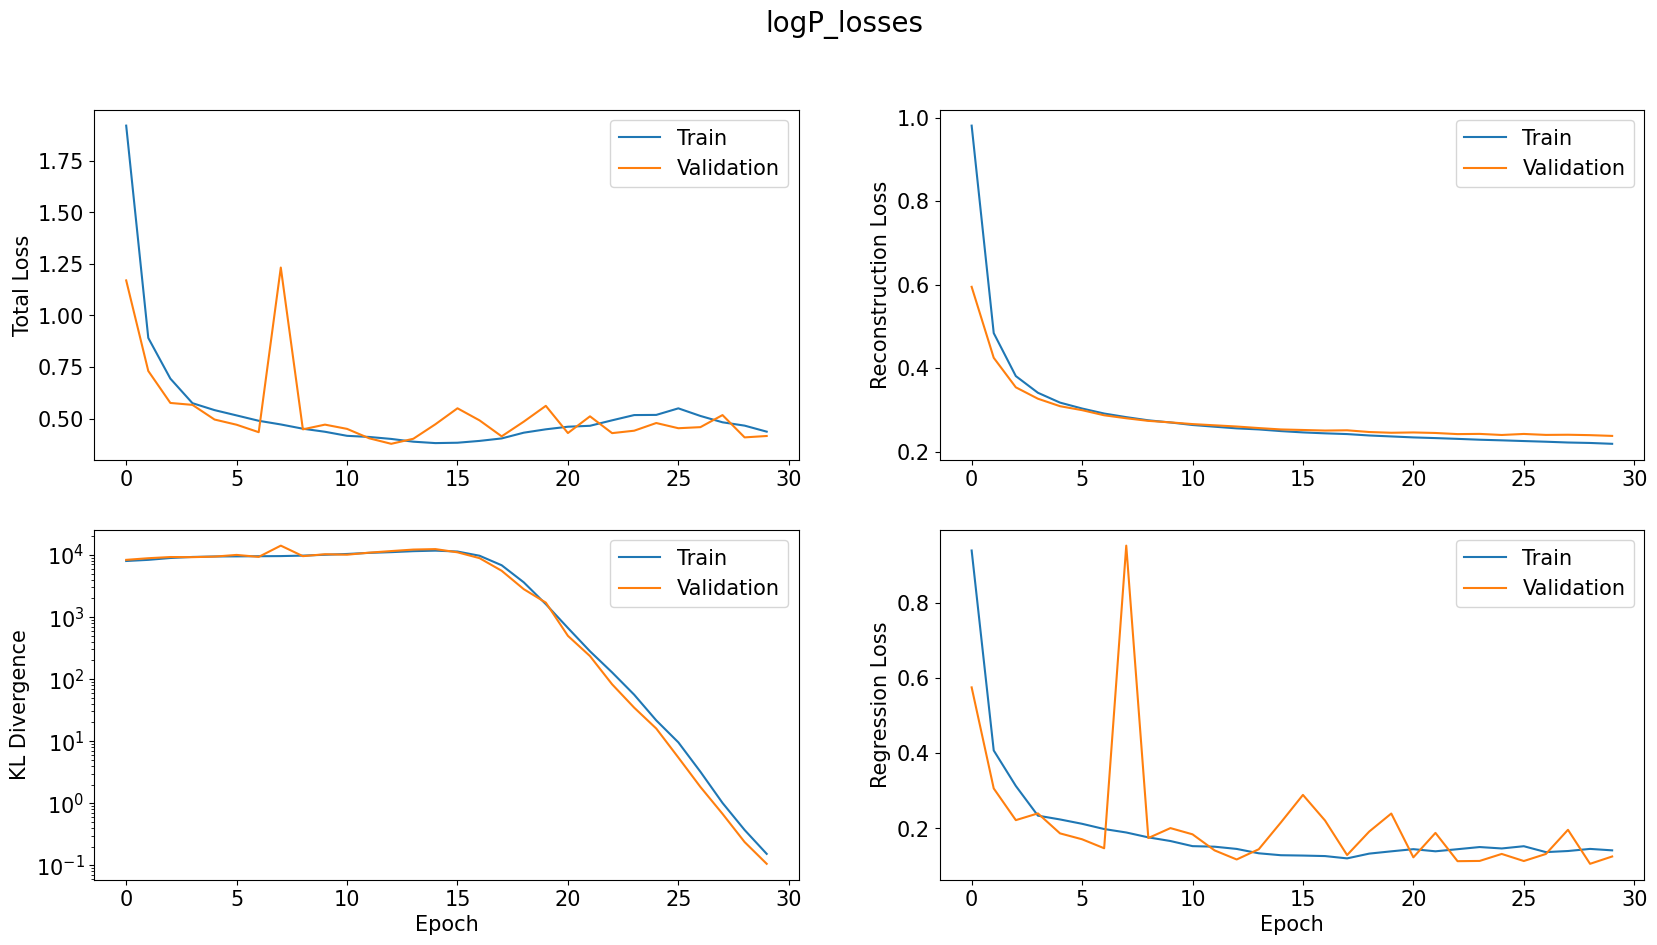

In [18]:
trainer.plot_losses()

In [19]:
reg_mean_train = df.iloc[train_idx].reg_col.mean()
mean_mae_test = np.mean(np.abs(df.iloc[test_idx].reg_col - reg_mean_train))
vae_mae_test = get_pred_mae(reg_col, df, test_idx, bs).item()
errors[reg_col] = {'mean_mae_test': mean_mae_test, 'vae_mae_test': vae_mae_test}
errors

100%|██████████| 546/546 [00:00<00:00, 860.83it/s]


{'logP': {'mean_mae_test': 1.1192555519451162,
  'vae_mae_test': 0.2668350636959076}}

## Train and Test the Network for _QED_

In [20]:
reg_col = 'qed'
df, train_idx, valid_idx, test_idx = vae_utils.get_train_valid_test_splits(reg_col, valid_pct)
trainer = Trainer(reg_col)
# train_dl, valid_dl = get_dataloaders(df, train_idx, valid_idx, max_samples, bs)
# trainer.fit(epochs, save_every, anneal_start, lr, train_dl, valid_dl, device, load_previous)
df.head()

Length of DataFrame: 249455
Length of Training Set: 224018
Length of Validation Set: 24891
Length of Test Set: 546


,smiles,reg_col
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1 ...,0.702012
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1 ...,0.928975
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,0.599682
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,0.690944
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,0.789027


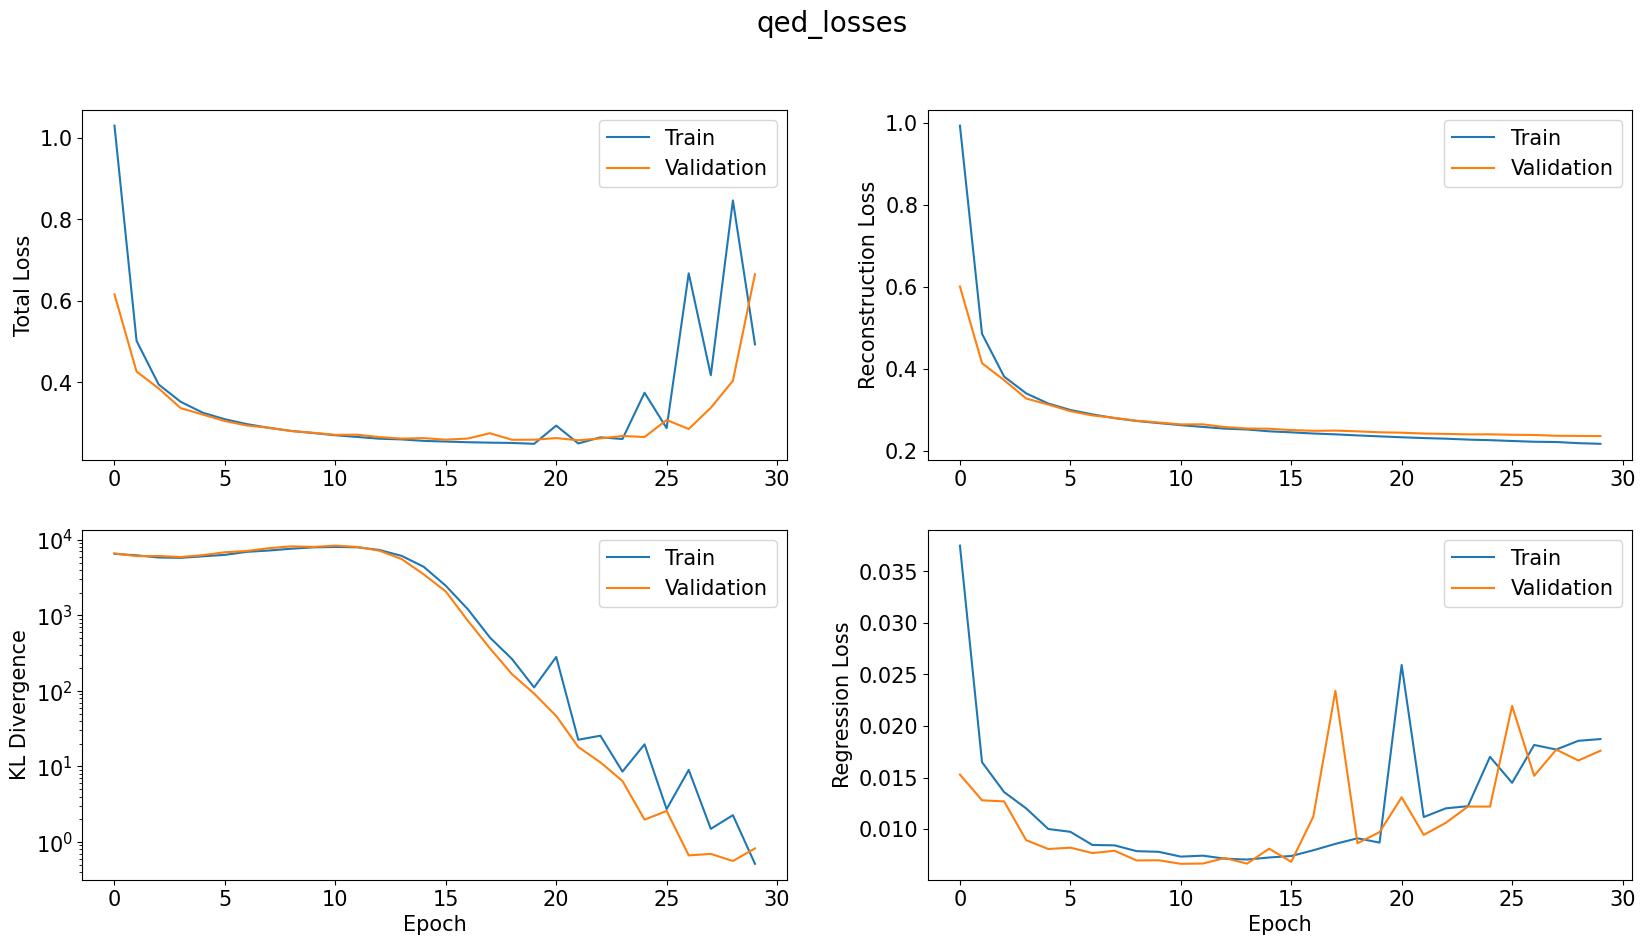

In [21]:
trainer.plot_losses()

In [22]:
reg_mean_train = df.iloc[train_idx].reg_col.mean()
mean_mae_test = np.mean(np.abs(df.iloc[test_idx].reg_col - reg_mean_train))
vae_mae_test = get_pred_mae(reg_col, df, test_idx, bs).item()
errors[reg_col] = {'mean_mae_test': mean_mae_test, 'vae_mae_test': vae_mae_test}
errors

100%|██████████| 546/546 [00:00<00:00, 901.26it/s]


{'logP': {'mean_mae_test': 1.1192555519451162,
  'vae_mae_test': 0.2668350636959076},
 'qed': {'mean_mae_test': 0.10747160129061648,
  'vae_mae_test': 0.10584615170955658}}

## Train and Test the Network for _SAS_

In [23]:
reg_col = 'SAS'
df, train_idx, valid_idx, test_idx = vae_utils.get_train_valid_test_splits(reg_col, valid_pct)
trainer = Trainer(reg_col)
# train_dl, valid_dl = get_dataloaders(df, train_idx, valid_idx, max_samples, bs)

Length of DataFrame: 249455
Length of Training Set: 224018
Length of Validation Set: 24891
Length of Test Set: 546


In [24]:
df.head()

,smiles,reg_col
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1 ...,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1 ...,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,4.035182


In [25]:
# trainer.fit(epochs, save_every, anneal_start, lr, train_dl, valid_dl, device, load_previous)
df.head()

,smiles,reg_col
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1 ...,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1 ...,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,4.035182


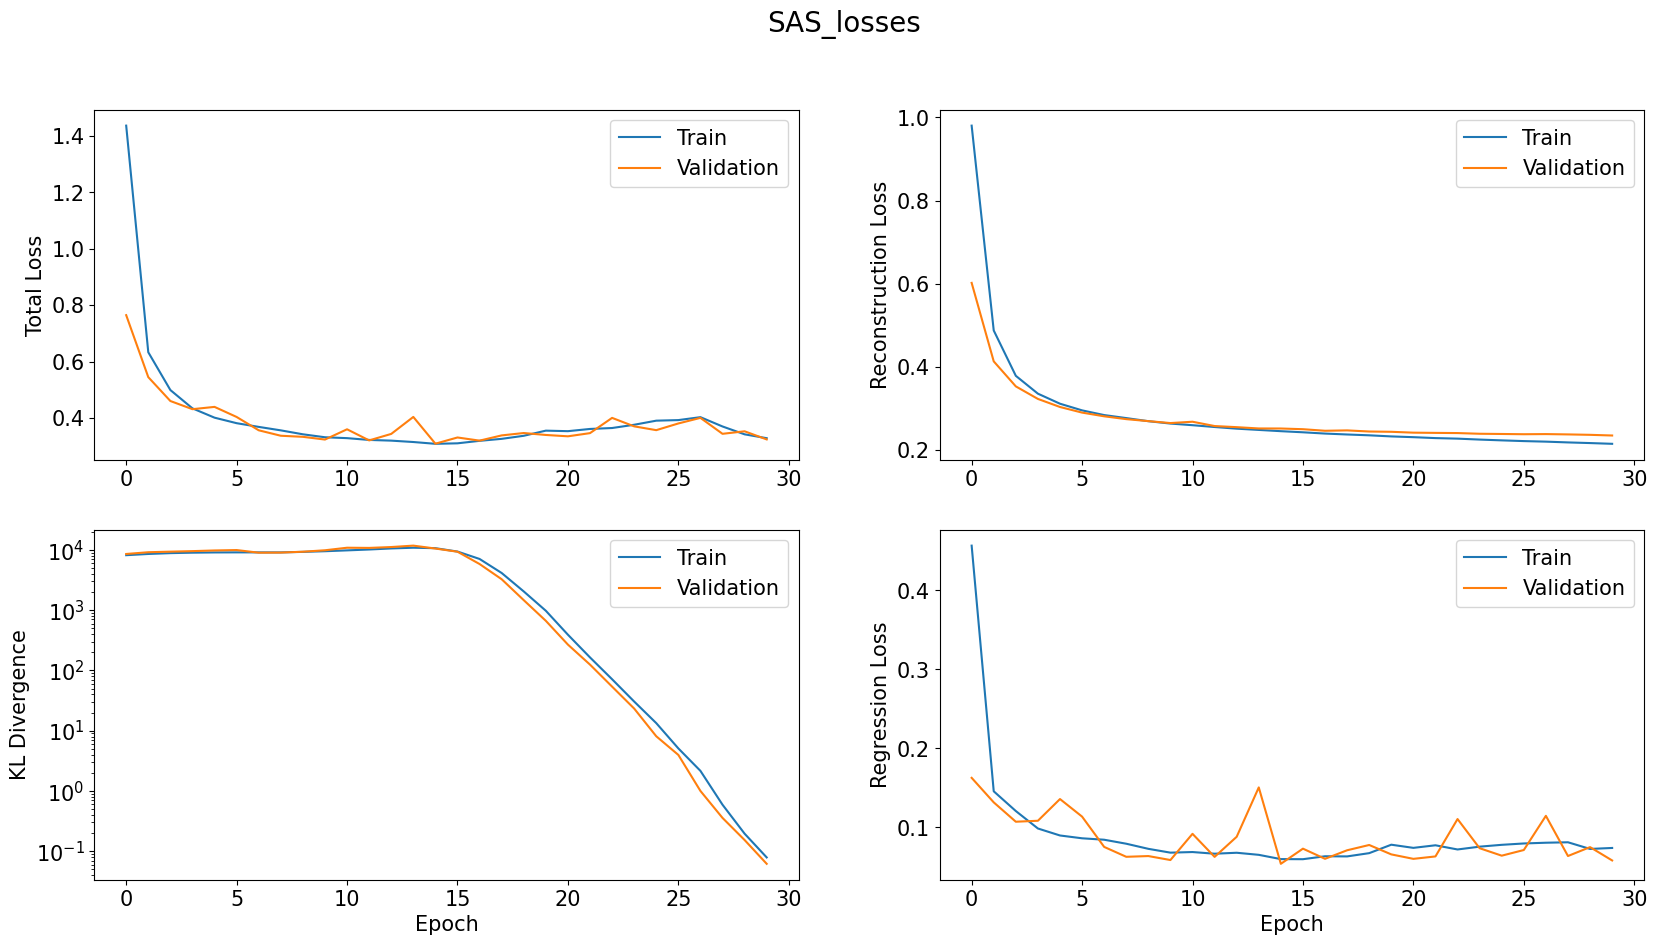

In [26]:
trainer.plot_losses()

In [27]:
reg_mean_train = df.iloc[train_idx].reg_col.mean()
mean_mae_test = np.mean(np.abs(df.iloc[test_idx].reg_col - reg_mean_train))
vae_mae_test = get_pred_mae(reg_col, df, test_idx, bs).item()
errors[reg_col] = {'mean_mae_test': mean_mae_test, 'vae_mae_test': vae_mae_test}
errors

100%|██████████| 546/546 [00:00<00:00, 546.16it/s]


{'logP': {'mean_mae_test': 1.1192555519451162,
  'vae_mae_test': 0.2668350636959076},
 'qed': {'mean_mae_test': 0.10747160129061648,
  'vae_mae_test': 0.10584615170955658},
 'SAS': {'mean_mae_test': 0.6842563624900584,
  'vae_mae_test': 0.17659972608089447}}

## Report the Results

In [29]:
pd.DataFrame(errors).transpose()

,mean_mae_test,vae_mae_test
logP,1.119256,0.266835
qed,0.107472,0.105846
SAS,0.684256,0.176600
